In [1]:
from model.dataset import OpenCloseDataset
from model.gnn_model import GCN, GATv2
import os
from model.utils import train, device, train_epoch, eval_epoch, cross_val
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from torch_geometric.loader import DataLoader
import pandas as pd
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import global_mean_pool, GCNConv, GATConv

In [2]:
full_dataset = OpenCloseDataset(datafolder='../data', reload=False, k_degree=10).shuffle()
len(os.listdir('../data/processed'))

96

In [3]:
full_dataset[0]

Data(x=[420, 420], edge_index=[2, 5924], edge_attr=[5924], y=0)

In [24]:
full_dataset[0].edge_index

tensor([[  0,   0,   0,  ..., 419, 419, 419],
        [  1,   2,   3,  ..., 406, 407, 418]])

In [6]:
full_dataset[0]

Data(x=[420, 420], edge_index=[2, 5966], edge_attr=[5966], y=1)

In [25]:
full_dataset[0].edge_index

tensor([[  0,   0,   0,  ..., 419, 419, 419],
        [  1,   2,   3,  ..., 406, 407, 418]])

In [4]:
train_size = int(0.94 * len(full_dataset))
train_dataset, val_dataset = full_dataset[:train_size], full_dataset[train_size:]
#val_dataset, test_dataset = val_dataset[:-3], val_dataset[-3:]

In [13]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True)

In [20]:
model = GCN(full_dataset.num_features, channels=[256, 32, 8], dropout=0.1).to(device())
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()
epochs = 40
scheduler = lr_scheduler.StepLR(optimizer, step_size=epochs//3, gamma=0.1, last_epoch=-1, verbose=True)
sum(p.numel() for p in model.parameters())

Adjusting learning rate of group 0 to 1.0000e-03.


116858

In [21]:
history = train(model, epochs, train_loader, val_loader, loss, optimizer, scheduler=None)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 001, Train Loss: 0.0235, Test Loss 0.1189, Train Acc: 0.5114, Test Acc: 0.3333
Epoch: 002, Train Loss: 0.0234, Test Loss 0.1184, Train Acc: 0.5114, Test Acc: 0.3333
Epoch: 003, Train Loss: 0.0231, Test Loss 0.1172, Train Acc: 0.5341, Test Acc: 0.3333
Epoch: 004, Train Loss: 0.0229, Test Loss 0.1209, Train Acc: 0.5227, Test Acc: 0.3333
Epoch: 005, Train Loss: 0.0225, Test Loss 0.1203, Train Acc: 0.5682, Test Acc: 0.3333
Epoch: 006, Train Loss: 0.0220, Test Loss 0.1181, Train Acc: 0.7500, Test Acc: 0.3333
Epoch: 007, Train Loss: 0.0213, Test Loss 0.1291, Train Acc: 0.6591, Test Acc: 0.3333
Epoch: 008, Train Loss: 0.0205, Test Loss 0.1313, Train Acc: 0.7727, Test Acc: 0.3333
Epoch: 009, Train Loss: 0.0200, Test Loss 0.1192, Train Acc: 0.9205, Test Acc: 0.5000
Epoch: 010, Train Loss: 0.0189, Test Loss 0.1423, Train Acc: 0.7159, Test Acc: 0.3333
Epoch: 011, Train Loss: 0.0180, Test Loss 0.1295, Train Acc: 0.9659, Test Acc: 0.3333
Epoch: 012, Train Loss: 0.0166, Test Loss 0.1285, Trai

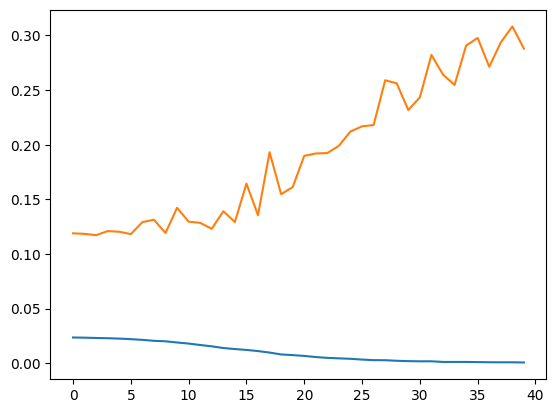

In [22]:
train_loss, val_loss = zip(*history)
# k = None no dropuot
plt.plot(train_loss)
plt.plot(val_loss);

In [17]:
model = GATv2(full_dataset.num_features, 128, 8).to(device())
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()
epochs = 40
scheduler = lr_scheduler.StepLR(optimizer, step_size=epochs//4, gamma=0.1, last_epoch=-1, verbose=False)
sum(p.numel() for p in model.parameters())

220722

In [18]:
history = train(model, epochs, train_loader, val_loader, loss, optimizer, scheduler=None)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 001, Train Loss: 0.0235, Test Loss 0.1103, Train Acc: 0.4886, Test Acc: 0.6667
Epoch: 002, Train Loss: 0.0226, Test Loss 0.1197, Train Acc: 0.6591, Test Acc: 0.3333
Epoch: 003, Train Loss: 0.0217, Test Loss 0.1306, Train Acc: 0.6477, Test Acc: 0.3333
Epoch: 004, Train Loss: 0.0205, Test Loss 0.1211, Train Acc: 0.7159, Test Acc: 0.5000
Epoch: 005, Train Loss: 0.0209, Test Loss 0.1129, Train Acc: 0.5795, Test Acc: 0.6667
Epoch: 006, Train Loss: 0.0171, Test Loss 0.1398, Train Acc: 0.8750, Test Acc: 0.3333
Epoch: 007, Train Loss: 0.0167, Test Loss 0.1238, Train Acc: 0.7386, Test Acc: 0.5000
Epoch: 008, Train Loss: 0.0152, Test Loss 0.1208, Train Acc: 0.7955, Test Acc: 0.5000
Epoch: 009, Train Loss: 0.0124, Test Loss 0.1614, Train Acc: 0.9205, Test Acc: 0.3333
Epoch: 010, Train Loss: 0.0105, Test Loss 0.1592, Train Acc: 0.9659, Test Acc: 0.5000
Epoch: 011, Train Loss: 0.0084, Test Loss 0.1703, Train Acc: 0.9886, Test Acc: 0.5000
Epoch: 012, Train Loss: 0.0071, Test Loss 0.1517, Trai

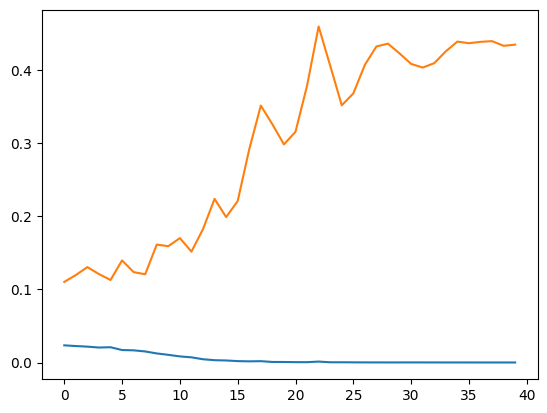

In [19]:
train_loss, val_loss = zip(*history)

plt.plot(train_loss)
plt.plot(val_loss);

In [17]:
torch.save(model.state_dict(), '../weights/gat_2heads_128_8_knn30.pt')

In [3]:
cross_val(full_dataset, GCN, lr=0.001, step_size=50//4, gamma=0.1, last_epoch=-1, verbose=False,
          num_features=full_dataset.num_features, channels=[256, 32, 8], dropout=0.3)

0it [00:00, ?it/s]

TypeError: __init__() got an unexpected keyword argument 'lr'

In [10]:
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm

skf = StratifiedKFold(n_splits=10, shuffle=True)
eval_metrics = np.zeros((skf.n_splits, 3))

labels = [full_dataset[i].y for i in range(len(full_dataset))]


for n_fold, (train_idx, test_idx) in tqdm(enumerate(skf.split(labels, labels))):
    model = GCN(full_dataset.num_features, 2, channels=[256, 32, 8], dropout=0.3).to(device())
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()
    scheduler = lr_scheduler.StepLR(optimizer, step_size=50//4, gamma=0.1, last_epoch=-1, verbose=False)

    train_loader_ = DataLoader(full_dataset[list(train_idx)], batch_size=8, shuffle=True)
    test_loader_ = DataLoader(full_dataset[list(test_idx)], batch_size=8, shuffle=True)
    min_v_loss = np.inf
    print(n_fold)
    pr, rc, acc = [], [], []
    for epoch in range(50):
        train_epoch(train_loader, model, criterion, optimizer)
        train_loss, train_acc, _, _ = eval_epoch(train_loader, model, criterion)
        val_loss, test_acc, _, _ = eval_epoch(val_loader, model, criterion)
        scheduler.step()
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Test Loss {val_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        #print(f'Train Prec: {train_pr:.3f}, Train Rec: {train_rc:.3f}, Test Prec: {val_pr:.3f}, Test Rec: {val_rc:.3f}')
        #rc.append(val_rc)
        #pr.append(val_pr)
        acc.append(test_acc)
        if min_v_loss > val_loss:
            min_v_loss = val_loss
            best_test_acc = test_acc

    eval_metrics[n_fold, 0] = best_test_acc
    eval_metrics[n_fold, 1] = np.mean(acc)
    eval_metrics[n_fold, 2] = np.std(acc)
### eval_metrics[n_fold, 3] =

0it [00:00, ?it/s]

Epoch: 000, Train Loss: 0.0865, Test Loss 0.2112, Train Acc: 0.4545, Test Acc: 0.6667
Epoch: 001, Train Loss: 0.0863, Test Loss 0.2283, Train Acc: 0.4886, Test Acc: 0.3333
Epoch: 002, Train Loss: 0.0859, Test Loss 0.2202, Train Acc: 0.5114, Test Acc: 0.6667
Epoch: 003, Train Loss: 0.0856, Test Loss 0.2265, Train Acc: 0.5227, Test Acc: 0.6667
Epoch: 004, Train Loss: 0.0854, Test Loss 0.2065, Train Acc: 0.5568, Test Acc: 1.0000
Epoch: 005, Train Loss: 0.0848, Test Loss 0.2246, Train Acc: 0.5455, Test Acc: 0.6667
Epoch: 006, Train Loss: 0.0840, Test Loss 0.2156, Train Acc: 0.6136, Test Acc: 0.6667
Epoch: 007, Train Loss: 0.0831, Test Loss 0.2139, Train Acc: 0.6364, Test Acc: 0.6667
Epoch: 008, Train Loss: 0.0820, Test Loss 0.2101, Train Acc: 0.6477, Test Acc: 0.6667
Epoch: 009, Train Loss: 0.0819, Test Loss 0.2072, Train Acc: 0.6364, Test Acc: 0.6667
Epoch: 010, Train Loss: 0.0820, Test Loss 0.1909, Train Acc: 0.6136, Test Acc: 1.0000
Epoch: 011, Train Loss: 0.0778, Test Loss 0.2059, Trai

In [11]:
eval_metrics

array([[0.66666667, 0.67333333, 0.08137704],
       [1.        , 0.72      , 0.13920409],
       [1.        , 0.59333333, 0.18      ],
       [1.        , 0.86666667, 0.17638342],
       [1.        , 0.66666667, 0.11547005],
       [1.        , 0.68666667, 0.1034945 ],
       [1.        , 0.68      , 0.09333333],
       [1.        , 0.85333333, 0.23247461],
       [1.        , 0.86666667, 0.25819889],
       [0.66666667, 0.7       , 0.1       ]])

In [16]:
np.mean(eval_metrics[:, 0]), np.std(eval_metrics[:, 0])

(0.9333333333333332, 0.13333333333333336)

In [18]:
np.mean(eval_metrics[:, 1]), np.std(eval_metrics[:, 1])

(0.7306666666666666, 0.0915641851380768)

In [19]:
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm

skf = StratifiedKFold(n_splits=10, shuffle=True)
eval_metrics = np.zeros((skf.n_splits, 3))

labels = [full_dataset[i].y for i in range(len(full_dataset))]


for n_fold, (train_idx, test_idx) in tqdm(enumerate(skf.split(labels, labels))):
    model = GATv2(full_dataset.num_features, 128, 8).to(device())
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()
    scheduler = lr_scheduler.StepLR(optimizer, step_size=50//4, gamma=0.1, last_epoch=-1, verbose=False)

    train_loader_ = DataLoader(full_dataset[list(train_idx)], batch_size=8, shuffle=True)
    test_loader_ = DataLoader(full_dataset[list(test_idx)], batch_size=8, shuffle=True)
    min_v_loss = np.inf
    print(n_fold)
    pr, rc, acc = [], [], []
    for epoch in range(50):
        train_epoch(train_loader, model, criterion, optimizer)
        train_loss, train_acc, _, _ = eval_epoch(train_loader, model, criterion)
        val_loss, test_acc, _, _ = eval_epoch(val_loader, model, criterion)
        scheduler.step()
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Test Loss {val_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        #print(f'Train Prec: {train_pr:.3f}, Train Rec: {train_rc:.3f}, Test Prec: {val_pr:.3f}, Test Rec: {val_rc:.3f}')
        #rc.append(val_rc)
        #pr.append(val_pr)
        acc.append(test_acc)
        if min_v_loss > val_loss:
            min_v_loss = val_loss
            best_test_acc = test_acc

    eval_metrics[n_fold, 0] = best_test_acc
    eval_metrics[n_fold, 1] = np.mean(acc)
    eval_metrics[n_fold, 2] = np.std(acc)
### eval_metrics[n_fold, 3] =

0it [00:00, ?it/s]

0
Epoch: 000, Train Loss: 0.0872, Test Loss 0.2138, Train Acc: 0.5000, Test Acc: 0.6667
Epoch: 001, Train Loss: 0.0851, Test Loss 0.2342, Train Acc: 0.5909, Test Acc: 0.3333
Epoch: 002, Train Loss: 0.0846, Test Loss 0.2182, Train Acc: 0.5227, Test Acc: 0.6667
Epoch: 003, Train Loss: 0.0813, Test Loss 0.2223, Train Acc: 0.6591, Test Acc: 0.6667
Epoch: 004, Train Loss: 0.0795, Test Loss 0.2135, Train Acc: 0.6818, Test Acc: 0.6667
Epoch: 005, Train Loss: 0.0826, Test Loss 0.2691, Train Acc: 0.5455, Test Acc: 0.3333
Epoch: 006, Train Loss: 0.0795, Test Loss 0.1939, Train Acc: 0.6364, Test Acc: 1.0000
Epoch: 007, Train Loss: 0.0734, Test Loss 0.2276, Train Acc: 0.7045, Test Acc: 0.6667
Epoch: 008, Train Loss: 0.0764, Test Loss 0.2646, Train Acc: 0.6477, Test Acc: 0.3333
Epoch: 009, Train Loss: 0.0801, Test Loss 0.2904, Train Acc: 0.5909, Test Acc: 0.3333
Epoch: 010, Train Loss: 0.0687, Test Loss 0.1715, Train Acc: 0.7500, Test Acc: 1.0000
Epoch: 011, Train Loss: 0.0715, Test Loss 0.1550, Tr

In [20]:
eval_metrics

array([[0.66666667, 0.65333333, 0.11469767],
       [1.        , 0.85333333, 0.25086517],
       [0.66666667, 0.61333333, 0.16812694],
       [1.        , 0.93333333, 0.18856181],
       [0.66666667, 0.64666667, 0.07916228],
       [1.        , 0.89333333, 0.21540659],
       [0.66666667, 0.87333333, 0.2096558 ],
       [0.66666667, 0.64666667, 0.1034945 ],
       [1.        , 0.9       , 0.20275875],
       [1.        , 0.96      , 0.12719189]])

In [21]:
np.mean(eval_metrics[:, 0]), np.std(eval_metrics[:, 0])

(0.8333333333333333, 0.16666666666666669)

In [22]:
np.mean(eval_metrics[:, 1]), np.std(eval_metrics[:, 1])

(0.7973333333333333, 0.13176409897152477)

In [ ]:
from captum.attr import Saliency, IntegratedGradients

def model_forward(edge_mask, data):
    batch = torch.zeros(data.x.shape[0], dtype=int).to(device())
    out = model(data) # .x, data.edge_index, batch, edge_mask
    return out


def explain(method, data, target=0):
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    return edge_mask